# Introduction

In this tutorial, we develop a simplified version of the grouped recall model described in the original ACT-R tutorial. We will develop more complex models of grouped recall in subsequent tutorials based on alternative assumptions. 

# Grouped Recall Task

The group recall task is a variation of the serial recall task in which items are organized hierarchically into groups. In this version of the task, the goal is to retrieve nine items in the originally presented order, which are organized into three groups of three. For ease of presentation, the items are ascending integers: (1,2,3), (4,5,6), (7,8,9). Of course, in practice, the items would not follow a simple counting rule. 


# Grouped Recall Model 1

The grouped recall model encodes items with a group and position id and uses the group and position id as retrieval cues for recalling the itmes. The strategy is quite simple: the model iterates through the group and position ids in ascending order, similar to a nested for loop:

In [1]:
for group in 1:3
    for position in 1:3
        println("retrieval request: group $group position $position")
    end
end

retrieval request: group 1 position 1
retrieval request: group 1 position 2
retrieval request: group 1 position 3
retrieval request: group 2 position 1
retrieval request: group 2 position 2
retrieval request: group 2 position 3
retrieval request: group 3 position 1
retrieval request: group 3 position 2
retrieval request: group 3 position 3


Upon retrieving a chunk, the model responds according to the value in the number slot, or "I don't know" in the case of a retrieval failure.

## Declarative memory

Declarative memory $M$ consists of a set of nine chunks, with slot set $Q = \{\textrm{group, position, retrieved, number}\}$. The values stored in the group and position slots index the group and position id, which encode information concerning order and serves as retrieval cues. The value stored in the number slot is the number to be remembered. The value stored in the slot called retrieved indicates whether the chunk has been previously retrieved. 


## Retrieval Request

On trial $i$, the retrieval request is defined as 

\begin{align}
    \mathbf{r}_i = \rm \{(position,v_1),(group, v_2), (retrieved,false)\}
\end{align}

where the corresponding slot set for the retrieval request is $Q_r = \rm \{position,group, retrieved\}$. 

## Inhibition of Return

Inhibition of return functions the same as with  [Serial Recall Model 1](../../../Tutorial_Models/Unit3/Serial_Recall_1/Serial_Recall_Model_1.ipynb). Once any chunk $m$ is marked as $c_m(\rm retrieved) = \textrm{true}$, it cannot be retrieved again. The set of chunks eligible for retrieval is defined as:

\begin{align}
    R = \{\mathbf{c}_m \in M: c_m(\rm retrieved) = \textrm{false}\}
\end{align}


## Activation

Activation for $\mathbf{c}_m \in R$ is given by the following equation:

\begin{align}
    a_{m} = \textrm{blc} + \rho_m + \epsilon_m
\end{align}


where the term blc represents base level constant, the term $\rho_m$ represents activation from partial matching, and $\epsilon \sim \textrm{Normal}(0, \sigma)$. Partial matching is given as:

\begin{equation}\label{eq:penalty}
\rho_m  = \delta \sum_{q \in Q_r}| c_m(q) - r_i(q) | 
\end{equation}

In the partial matching function above, the penalty for mismatching slot values is a linear distance function. The distance gradient is modulated by mismatch penality parameter $\delta$. 

## Response mapping

Let $y_i \in \{1,2, \dots 9, \emptyset \}, \forall_i$ be the set possible responses, where $\emptyset$ represents the response for a retrieval failure (e.g. "stating I don't know"). Thus, the response for trial $i$ is $y_i  = c_r(\textrm{number})$ if not a retrieval failure and $y_i = \emptyset$ in the case of a retrieval failure. 


## Response Probability

Let chunk $r$ be the retrieved chunk. The probability of retrieving $\mathbf{c}_r$ is given by the soft max function:

\begin{align}
     \Pr(Y_i = y_i \mid \delta ;\mathbf{r}_i) = \frac{e^{\frac{\mu_{r}}{\sigma}}}{\sum_{\mathbf{c}_k \in R} e^{\frac{\mu_k}{\sigma}} + e^{\frac{\mu_{m^\prime}}{\sigma}}}
\end{align}


## Likelihood Function

The likelihood function for the group recall model is given by

\begin{align}
L(\delta; \mathbf{Y}, \mathbf{r}_i) = \prod_{i=1}^N \Pr(Y_i = y_i \mid \delta ;\mathbf{r}_i )
\end{align}

where $\mathbf{Y} = \{y_1,y_2, \dots y_N \}$ is the set of responses. 

To begin, we will load the required files and libraries. 

In [2]:
# set the working directory to the directory in which this file is contained
cd(@__DIR__)
# load the package manager
using Pkg
# activate the project environment
Pkg.activate("../../../")
# load the required packages
using Turing, StatsPlots, Revise, ACTRModels
# load all model functions
include("Grouped_Recall_1.jl")
# seed random number generator
Random.seed!(78455);

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`


# Generate Data

In the code block below,  we will define a function called `simulate` to generate serial recall data for a single block. `simulate` requires the following arguments:

- n_groups: the number of groups with a default value of 3
- n_positions: the number of positions per group with a default value of 3
-$\delta$: the mismatch penalty parameter
-fixed_parms: a `NamedTuple` of fixed parameters and settings

`simulate` begins by initializing declarative memory and the model object. Next, begins a series of memory retrievals to retrieve the items in the correct order, using the group and position ids as retrieval cues. Implicitly, a set of production rules provide a control structure to perform this sequence of memory retrievals. The outer loop iterates through each group id in order. For each group id, the inner loop iterates through the position ids in order, starting with 1 and ending after 3. The `group` and `position` indices serve as a retrieval cue. If a chunk is retrieved, the value in the `number` slot is added to the data and the value in the `retrieved` slot is set to false to prevent duplicate responses. Retrieval failures are coded as -100.

In [3]:
function simulate(n_groups=3, n_positions=3; δ, fixed_parms...)
    # initialize memory with chunks representing all stimuli
    chunks = populate_memory()
    # add chunks to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACT-R model object
    actr = ACTR(;declarative=memory, δ, fixed_parms...)
    N = n_groups*n_positions
    # initialize data for all trials
    data = Array{NamedTuple,1}(undef,N)
    cnt = 0
    # inhabition of return: exclude retrieved chunks
    retrieved=[false]
    # loop over all groups in asecnding order
    for group in 1:n_groups
        # loop over all positions within a group in ascending order
        for position in 1:n_positions
            cnt += 1
            # retrieve chunk given group and position indices
            # exclude retrieved chunks
            probs,r_chunks = retrieval_probs(actr; group, position, retrieved)
            n_probs = length(probs)
            idx = sample(1:n_probs, Weights(probs))
            if idx == n_probs
                # code retrieval failure as -100
                data[cnt] = (group=group,position=position,resp=-100)
            else
                # set chunk to retrieved = true for inhabition of return
                chunk = r_chunks[idx] 
                chunk.slots.retrieved[1] = true
                # record the number value of the retrieved chunk
                data[cnt] = (group=group,position=position,resp=chunk.slots.number)
            end
        end
    end
    return vcat(data...)
end

simulate (generic function with 3 methods)

Now that our `simulate` function has been defined, we can now generate some data. The code block below generates data for 5 blocks, resulting in 45 responses. The data for each block is stored in an array of `NamedTuples` where the group id, position id and response are stored for each trial in a seperate `NamedTuple`. All blocks are nested within an array. The first block of simulated data is printed below. 

In [4]:
# fixed parameters and settings
fixed_parms = (s = 0.15,τ = -0.5,noise = true,mmp = true,mmpFun = simFun)
# mismatch penalty parameter for partial matching
δ = 1.0
# the number of blocks
n_blocks = 5
Data = map(x -> simulate(;δ, fixed_parms...), 1:n_blocks)
Data[1]

9-element Vector{NamedTuple{(:group, :position, :resp), Tuple{Int64, Int64, Int64}}}:
 (group = 1, position = 1, resp = 1)
 (group = 1, position = 2, resp = 2)
 (group = 1, position = 3, resp = 3)
 (group = 2, position = 1, resp = 4)
 (group = 2, position = 2, resp = 5)
 (group = 2, position = 3, resp = -100)
 (group = 3, position = 1, resp = 7)
 (group = 3, position = 2, resp = -100)
 (group = 3, position = 3, resp = 9)

## Define Log Likelihood Function


Two functions are used to compute the log likelihood. The function `computeLL` initializes the ACT-R model object and loops over the data for each block. It requires the following arguments:

- Data: an array of arrays of `NamedTuples`. Each sub-array contains trials within a block and each trial
    contains the group id, position id and response
- fixed_parms: a `NamedTuple` of fixed parameters and model settings
- $\delta$: a keyword argument for the mismatch penalty parameter

Within the for loop, `computeLL` computes the log likelihood for a given block of data using the function `computeLLBlock`. Next, the value of the slot "retrieved" of each chunk is reset to false with the function `reset_memory!`. 

The function `computeLLBlock` computes the log likelihood of each trial in a given block. `computeBlockLL` requires the following arguments:

- Data: an array of arrays of `NamedTuples`. Each sub-array contains trials within a block and each trial
    contains the group id, position id and response
- actr: an ACT-R model object
- $\delta$: a keyword argument for the mismatch penalty parameter

Inside the for loop of `computeBlockLL`, the log probability of a retrieval failure is computed if the response is -100. Otherwise, the log probability of retrieving the chunk associated with the recorded response is computed and the value of the `retrieved` slot is set to false for inhibition of return. 

In [5]:
function computeLL(Data, fixed_parms; δ)
    T = typeof(δ)
    act = zero(T)
    # initialize chunks
    chunks = populate_memory(act)
    # add chunks to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACT-R object with declarative memory and parameters
    actr = ACTR(;declarative=memory, fixed_parms..., δ)
    LL::T = 0.0
    # loop over each block of trials
    for data in Data
        # log likelihood of block of trials
        LL += computeLLBlock(data, actr; δ)
        # reset all chunks to retrieved = false
        reset_memory!(actr)
    end
    return LL
end

function computeLLBlock(data, actr; δ)
    # initialize log likelihood
    LL = 0.0
    # inhabition of return: exclude retrieved chunks
    retrieved = [false]
    for k in data
        if k.resp == -100
            # log likelihood of retrieval failure given retrieval request for group and position indices
            p,_ = retrieval_probs(actr; group=k.group, position=k.position, retrieved)
            LL += log(p[end])
        else
            # get retrieved chunk
            chunk = get_chunks(actr; number=k.resp)
            # log likelihood of retrieving chunk given retrieval request for group and position indices
            p,_ = retrieval_prob(actr,chunk; group=k.group, position=k.position, retrieved)
            # set the retrieved chunk to retrieved = true for inhabition of return 
            chunk[1].slots.retrieved[1] = true
            LL += log(p)
        end
    end
    return LL
end

computeLLBlock (generic function with 1 method)

## Define Model

We can summarize the prior and model as follows:

\begin{align}
\delta \sim \rm Normal(1.0,.5)
\end{align}

\begin{align}
\theta_i = \textrm{Pr}(Y_i = y_i | \mathbf{r}_i)
\end{align}

\begin{align}
y_{i} \sim \rm Bernouli(\theta_i)
\end{align}

In the code block below, the model is specified for Turing. 

In [6]:
@model model(Data, fixed_parms) = begin
    δ ~ truncated(Normal(1, 1.0), 0, Inf)
    Data ~ Grouped(δ, fixed_parms)
end

model (generic function with 1 method)

## Estimate Parameters

Now that the priors, likelihood and Turing model have been specified, we can now estimate the parameters. In the following code, we will run four MCMC chains with the NUTS sample for 2,000 iterations and omit the first 1,000 warmup samples. 

In [7]:
# number of samples retained after warmup
n_samples = 1000
# the number of warmup or adaption samples
n_adapt = 1000
# the number of MCMC chains
n_chains = 4
# settings for the sampler
specs = NUTS(n_adapt, 0.8)
# estimate the parameters
chain = sample(model(Data, fixed_parms), specs, MCMCThreads(), n_samples, n_chains, progress=true)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.70234375
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current propos

Chains MCMC chain (1000×13×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = δ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           δ    1.1946    0.1834     0.0029    0.0037   1564.5790    1.0020

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           δ    0.8620    1.0658    1.1876    1.3091    1.5692


## Results

### Diagnostics

The first panel for each plot shows good mixing between the four chains. Additionally, in the summary above, $r\hat \approx 1$ for the parameter $\delta$. Auto-correlation in the second panel drops rapidly after a lag of about 3-5, indicating efficient sampling.

### Posterior Distributions

As expected, the density plot located in the third panel shows that the posterior distribution is centered near the data-generating parameter values of $\delta = 1$. 

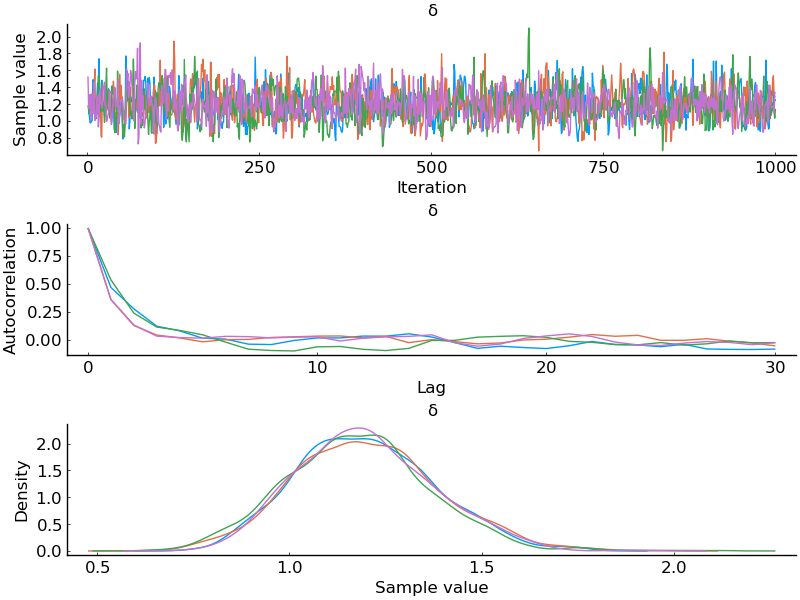

In [8]:
pyplot()
font_size = 12
ch = group(chain, :δ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

### Posterior Predictive Distributions

#### Transposition Errors

The plot below shows the posterior predictive distribution of transposition errors. The x-axis represents the displacement or absolute difference between the correct number and the retrieved number. The posterior predictive distribution indicates that a displacement of zero (e.g. a correct response) is the most likely observation. Displacement values greater than zero are less likely. 

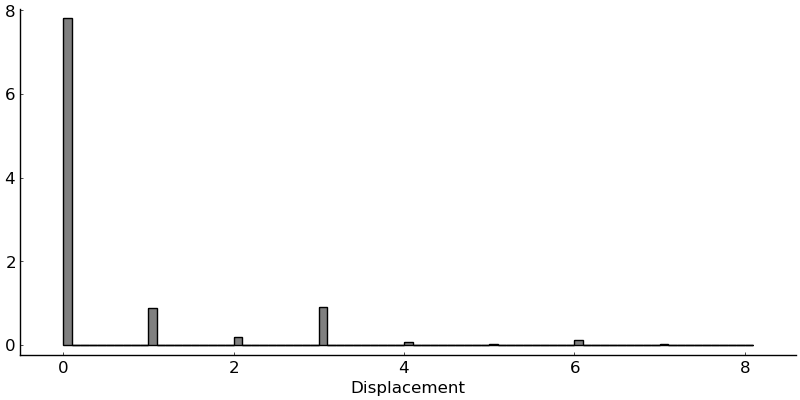

In [9]:
preds = posterior_predictive(x -> simulate(;fixed_parms..., x...), chain, 1000, displacement)
preds = vcat(preds...)
p4 = histogram(preds, xaxis=font(12), yaxis=font(12), grid=false, size=(800,400), norm=true,
    titlefont=font(7), leg=false, color=:grey, xlabel="Displacement")